# TFRecord and tf.train.Example

TFRecord 파일은 주로 대용량 데이터를 효율적으로 저장하고 읽기 위해 사용

 - Colab에서 데이터를 불러올 때 대기시간이 오래 걸렸다면? 이걸 써야합니다.
 - 주로 숫자나 텍스트 데이터(.csv)에는 효과적이지 못하고, 이미지처럼 불러오는 과정이 복잡할 때 매우 효과적

  → 만들 때는 귀찮을 때 막상 만들면 편함

 - 구글의 Protocol Buffer 포멧으로 데이터 파일을 이진 레코드 형태로 저장
   (프로토콜 메시지는 `.proto`로 정의됨)
 - TFRecord 파일 생성은
 
   ① 기록하고자 하는 데이터의 feature들을 python dictionary 형태로 정의한 후,
   
   ② 데이터 하나씩 `tf.train.Example` 객체로 만들어 `tf.io.TFRecordWriter` 형태로 저장

This notebook demonstrates how to create, parse, and use the `tf.train.Example` message, and then serialize, write, and read `tf.train.Example` messages to and from `.tfrecord` files.

Note: While useful, these structures are optional. There is no need to convert existing code to use TFRecords, unless you are [using tf.data](https://www.tensorflow.org/guide/data) and reading data is still the bottleneck to training. You can refer to [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance) for dataset performance tips.

→ 이미 tf.data를 사용중이거나, 훈련 중에 병목현상이 발생되지 않는다면 기존 코드를 변환할 필요까지는 없다 (소 잡는 칼을 닭 잡는데 이용하지 않아도 된다는 얘기)

Note: In general, you should shard your data across multiple files so that you can parallelize I/O (within a single host or across multiple hosts). The rule of thumb is to have at least 10 times as many files as there will be hosts reading data. At the same time, each file should be large enough (at least 10 MB+ and ideally 100 MB+) so that you can benefit from I/O prefetching. For example, say you have `X` GB of data and you plan to train on up to `N` hosts. Ideally, you should shard the data to ~`10*N` files, as long as ~`X/(10*N)` is 10 MB+ (and ideally 100 MB+). If it is less than that, you might need to create fewer shards to trade off parallelism benefits and I/O prefetching benefits.

→ 13.1에서 배웠던 prefetch를 활용하기 위해 큰 파일은 대체로 10개 이상으로 쪼개는 것이 효율적이다

## Setup

In [ ]:
import tensorflow as tf

import numpy as np
import IPython.display as display

## `tf.train.Example`

### Data types for `tf.train.Example`

Fundamentally, a `tf.train.Example` is a `{"string": tf.train.Feature}` mapping.

The `tf.train.Feature` message type can accept one of the following three types (See the [`.proto` file](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/example/feature.proto) for reference). Most other generic types can be coerced into one of these:

1. `tf.train.BytesList` (the following types can be coerced)

  - `string`
  - `byte`

1. `tf.train.FloatList` (the following types can be coerced)

  - `float` (`float32`)
  - `double` (`float64`)

1. `tf.train.Int64List` (the following types can be coerced)

  - `bool`
  - `enum`
  - `int32`
  - `uint32`
  - `int64`
  - `uint64`

아래의 함수를 사용하여 `tf.train.Feature`와 호환가능한 `tf.Example`로 변환 가능

각 함수는 스칼라 입력 값 사용, 위 세가지 `list` 타입 중 하나로 되어있는 `tf.train.Feature` 반환

문자열 타입의 데이터는 `tf.train.BytesList`의 객체로 기록된다는 것

In [ ]:
# 다음의 함수들을 사용하여 값을 tf.example과 호환되는 형식으로 변환할 수 있음
# with tf.train.Example.

def _bytes_feature(value):
  """string/byte를 byte_list로 변환함"""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor. 텐서플로 2.0에서 기본적으로 제공되는 'eagertensor'에서는 string을 빼내지 못하므로 numpy형태로 변환
    #텐서플로 1.0에서는 즉시 계산이 되지 않는 단점을 텐서플로 2.0에서 eagertensor로 즉시 계산가능한 기능 포함
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """float/double을 float_list로 변환함."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """bool/enum/int/unit을 int64_list로 변환함"""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

Note: 만약 논-스칼라 feature에 대해서는 binary-strings로 변환하기 위해  `tf.io.serialize_tensor` 사용.

이후 `tf.io.parse_tensor`로 tensor 형태로 또 변환

< 간단한 예시 >

In [ ]:
print(_bytes_feature(b'test_string'))
print(_bytes_feature(u'test_bytes'.encode('utf-8')))

print(_float_feature(np.exp(1)))

print(_int64_feature(True))
print(_int64_feature(1))
#byte_feature, float_feature, int64_feature 내에 기록이 됩니다. 하지만 마지막 줄의 1이 1.0이 된다면? 1.0이 float이기 때문에 에러가 뜹니다. float_feature를 써야 맞습니다

bytes_list {
  value: "test_string"
}

bytes_list {
  value: "test_bytes"
}

float_list {
  value: 2.7182817459106445
}

int64_list {
  value: 1
}

int64_list {
  value: 1
}



모든 프로토 메시지는 `.SerializeToString` 메써드를 사용하여 이진 문자열로 직렬화 가능함

In [ ]:
feature = _float_feature(np.exp(1))

feature.SerializeToString()

b'\x12\x06\n\x04T\xf8-@'

### Creating a `tf.train.Example` message

Suppose you want to create a `tf.train.Example` message from existing data. 무슨 데이터이든간에 아래 단계를 통해야한다는 것은 동일함

1. 각 관측치 내의 값을 데이터 타입과 맞게 위의 3개의 함수를 각각 이용하여 `tf.train.Feature`로 변환, 매핑된 dictionary로 생성

1. 1단계에서 생성된 map을 [`Features` message](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/example/feature.proto#L85)로 변환함

In this notebook, you will create a dataset using NumPy.

This dataset will have 4 features:

* a boolean feature, 동일한 확률의 `False` or `True`
*  `[0, 5]` 사이에 균일하게 선택된 임의의 정수
* 정수 feature를 인덱스로 하는 문자열 테이블에서 생성된 string feature
* 표준 정규분포를 따르는 실수형 feature

10,000개의 독립적, 동일한 분포의 관측치로 구성된 표본을 사용해보면...?

In [ ]:
# The number of observations in the dataset.
n_observations = int(1e4)

# Boolean feature, encoded as False or True.
feature0 = np.random.choice([False, True], n_observations)

# Integer feature, random from 0 to 4.
feature1 = np.random.randint(0, 5, n_observations)

# String feature.
strings = np.array([b'cat', b'dog', b'chicken', b'horse', b'goat'])
feature2 = strings[feature1]

# Float feature, from a standard normal distribution.
feature3 = np.random.randn(n_observations)

각 feature는 `_bytes_feature`, `_float_feature`, `_int64_feature` 중 하나를 사용해서 호환되는 `tf.train.Example`로 만들어진 후 `tf.train.Example` message로 생성됨 

In [ ]:
def serialize_example(feature0, feature1, feature2, feature3):
  """
  Creates a tf.train.Example message ready to be written to a file.
  """
  # Create a dictionary mapping the feature name to the tf.train.Example-compatible
  # data type.
  feature = {
      'feature0': _int64_feature(feature0),
      'feature1': _int64_feature(feature1),
      'feature2': _bytes_feature(feature2),
      'feature3': _float_feature(feature3),
  }

  # Create a Features message using tf.train.Example.

  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

시범적으로 single observation `[False, 4, bytes('goat'), 0.9876]`.를 serialize_example 함수를 이용해서 binary string으로 serialize 가능

In [ ]:
# This is an example observation from the dataset.

example_observation = []

serialized_example = serialize_example(False, 4, b'goat', 0.9876)
serialized_example

b'\nR\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04[\xd3|?\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04'

serialization된 데이터를 `tf.train.Example.FromString` method로 다시 decode도 가능

In [ ]:
example_proto = tf.train.Example.FromString(serialized_example)
example_proto

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 4
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "goat"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 0.9876000285148621
      }
    }
  }
}

## TFRecord files in Python

`tf.io` module로 TFRecord 파일을 읽고 쓸 수 있음

### Writing a TFRecord file

`tf.io.TFRecordWriter`를 이용해서 `test.tfrecord`라는 파일명으로 4개의 feature를 가진 10,000개의 샘플값을 저장해보자

In [ ]:
filename='test.tfrecord'

In [ ]:
# `tf.Example` 데이터를 tfrecord 파일에 write하기
with tf.io.TFRecordWriter(filename) as writer:
  for i in range(n_observations):
    example = serialize_example(feature0[i], feature1[i], feature2[i], feature3[i])
    writer.write(example)

In [ ]:
!du -sh {filename} #용량 확인

984K	/root/.keras/datasets/194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg


### Reading a TFRecord file

그리고 저장한 값을 `tf.data.TFRecordDataset`과 `tf.train.Example.ParseFromString`로 파싱하고 읽어보자



In [ ]:
filenames = [filename]
raw_dataset = tf.data.TFRecordDataset(filenames) # 일단 TFRecord 읽어오고...
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [ ]:
for raw_record in raw_dataset.take(2): #하나만 해봐유
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy()) #읽어온 놈을 파싱하기!
  print(example)

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 2
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "chicken"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 1.4887728691101074
      }
    }
  }
}

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 2
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "chicken"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: -1.5159639120101929
      }
    }
  }
}



## 예제: Reading and writing image data

TFRecord를 사용하여 이미지 데이터를 읽고 써보자.

특히 이미지 데이터를 raw 데이터 상태가 아닌 TFRecord 형태로 전처리 할 수 있고, 모델링에도 사용할 수 있어서 편리함

사용할 이미지 ☞ [this image](https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg) of a cat in the snow and [this photo](https://upload.wikimedia.org/wikipedia/commons/f/fe/New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg) of the Williamsburg Bridge, NYC under construction.

### Fetch the images

In [ ]:
cat_in_snow  = tf.keras.utils.get_file(
    '320px-Felis_catus-cat_on_snow.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg')

williamsburg_bridge = tf.keras.utils.get_file(
    '194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg')

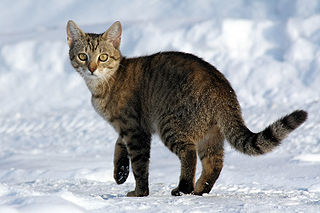

In [ ]:
display.display(display.Image(filename=cat_in_snow))
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

In [ ]:
display.display(display.Image(filename=williamsburg_bridge))
display.display(display.HTML('<a "href=https://commons.wikimedia.org/wiki/File:New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg">From Wikimedia</a>'))

### Write the TFRecord file

As before, encode the features as types compatible with `tf.train.Example`. This stores the raw image string feature, as well as the height, width, depth, and arbitrary `label` feature. The latter is used when you write the file to distinguish between the cat image and the bridge image. Use `0` for the cat image, and `1` for the bridge image:

In [ ]:
image_labels = {
    cat_in_snow : 0,
    williamsburg_bridge : 1,
}

In [ ]:
# This is an example, just using the cat image.
image_string = open(cat_in_snow, 'rb').read()

label = image_labels[cat_in_snow]

# Create a dictionary with features that may be relevant.
def image_example(image_string, label):
  image_shape = tf.io.decode_jpeg(image_string).shape

  feature = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image_string),
  }

  return tf.train.Example(features=tf.train.Features(feature=feature))

for line in str(image_example(image_string, label)).split('\n')[:15]:
  print(line)
print('...')

features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 213
      }
...


Notice that all of the features are now stored in the `tf.train.Example` message. Next, functionalize the code above and write the example messages to a file named `images.tfrecords`:

In [ ]:
# Write the raw image files to `images.tfrecords`.
# First, process the two images into `tf.train.Example` messages.
# Then, write to a `.tfrecords` file.
record_file = 'images.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
  for filename, label in image_labels.items():
    image_string = open(filename, 'rb').read()
    tf_example = image_example(image_string, label)
    writer.write(tf_example.SerializeToString())

InvalidArgumentError: ignored

In [ ]:
!du -sh {record_file}

20K	images.tfrecords


### Read the TFRecord file

You now have the file—`images.tfrecords`—and can now iterate over the records in it to read back what you wrote. Given that in this example you will only reproduce the image, the only feature you will need is the raw image string. Extract it using the getters described above, namely `example.features.feature['image_raw'].bytes_list.value[0]`. You can also use the labels to determine which record is the cat and which one is the bridge:

In [ ]:
raw_image_dataset = tf.data.TFRecordDataset('images.tfrecords')

# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {depth: (), height: (), image_raw: (), label: (), width: ()}, types: {depth: tf.int64, height: tf.int64, image_raw: tf.string, label: tf.int64, width: tf.int64}>

Recover the images from the TFRecord file:

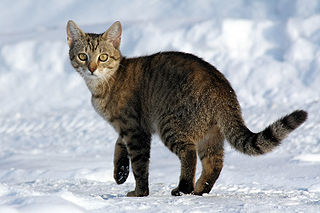

In [ ]:
for image_features in parsed_image_dataset:
  image_raw = image_features['image_raw'].numpy()
  display.display(display.Image(data=image_raw))

  #아 못해먹겠네